The data comes from here: https://www.kaggle.com/datasets/fmena14/crowd-counting/data

In [13]:
import scipy.io
import os
from skimage import io, color, transform, exposure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
imagepath = '../../data/crowd/frames'
labels = pd.read_csv('../../data/crowd/labels.csv')
labels.head()

,id,count
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


In [31]:
filelist = os.listdir(imagepath)
filelist = sorted(filelist)
filelist = filelist[1:]
# img = io.imread(imagepath + '/' + filelist[0])
# io.imshow(img)

In [33]:
counts = np.array(labels['count'])
alldata = {'imagefiles':filelist, 'counts':counts}
alldata = pd.DataFrame(alldata)
alldata.head()

,imagefiles,counts
0,seq_000001.jpg,35
1,seq_000002.jpg,41
2,seq_000003.jpg,41
3,seq_000004.jpg,44
4,seq_000005.jpg,41


In [34]:
from random import shuffle
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split



In [35]:
INPUT_SIZE = 256
BATCH_SIZE = 32


In [36]:
def preprocess(img):
    if len(img.shape)==2:
        img = np.stack([img, img, img], axis = 2)

    img = img - np.min(img)
    img = img / np.max(img)
    
    img = img - np.mean(img)
    img = img / np.std(img)   
    return img


In [37]:
traindata, testdata = train_test_split(alldata, test_size=0.2)
print(traindata.shape,testdata.shape)
traindata = traindata.sample(frac=1.0)

(1600, 2) (400, 2)


In [38]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_epsilon=1e-06,
                                rotation_range=5,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.5,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=True,
                                vertical_flip=False,
                                rescale=None,
                                preprocessing_function=preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )


In [39]:
training_set = train_datagen.flow_from_dataframe(
                                            dataframe=traindata,
                                            directory=imagepath,
                                            x_col="imagefiles",
                                            y_col="counts",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="raw",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe( dataframe=traindata,
                                            directory=imagepath,
                                            x_col="imagefiles",
                                            y_col="counts",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="raw",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='validation',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                            )

Found 1280 validated image filenames.
Found 320 validated image filenames.


In [90]:
model = Sequential()

model.add(InputLayer(input_shape=[INPUT_SIZE,INPUT_SIZE,3])) #keras will internally add batch dimension

model.add(Conv2D(filters=96,kernel_size=5,strides=3,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=3,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=3,strides=2,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_absolute_error', 'mean_squared_error'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 86, 86, 96)        7296      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 29, 29, 96)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 29, 29, 96)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 15, 15, 128)       110720    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 8, 8, 128)        

In [91]:
#Training

epochs = 50
history = model.fit(training_set,
               epochs=epochs,
               validation_data=validation_set)

model.save_weights("crowd-model-" + str(epochs) + ".weights.h5")
print("Saved model to disk after",epochs,"epochs.")


Epoch 1/50
40/40 [==============================] - 10s 237ms/step - loss: 7.6121 - mean_absolute_error: 7.6121 - mean_squared_error: 101.8549 - val_loss: 8.6743 - val_mean_absolute_error: 8.6743 - val_mean_squared_error: 104.0676
Epoch 2/50
40/40 [==============================] - 9s 229ms/step - loss: 5.5453 - mean_absolute_error: 5.5453 - mean_squared_error: 49.6079 - val_loss: 9.8235 - val_mean_absolute_error: 9.8235 - val_mean_squared_error: 123.6236
Epoch 3/50
40/40 [==============================] - 9s 226ms/step - loss: 5.3753 - mean_absolute_error: 5.3753 - mean_squared_error: 46.4744 - val_loss: 7.7513 - val_mean_absolute_error: 7.7513 - val_mean_squared_error: 81.0161
Epoch 4/50
40/40 [==============================] - 9s 224ms/step - loss: 5.4799 - mean_absolute_error: 5.4799 - mean_squared_error: 48.4127 - val_loss: 7.1144 - val_mean_absolute_error: 7.1144 - val_mean_squared_error: 70.4234
Epoch 5/50
40/40 [==============================] - 9s 227ms/step - loss: 5.2327 - m

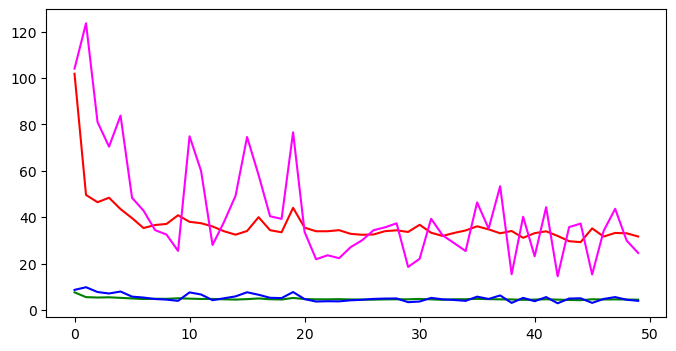

In [96]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['mean_squared_error'],color='red')
plt.plot(history.history['mean_absolute_error'],color='green')
plt.plot(history.history['val_mean_squared_error'],color='magenta')
plt.plot(history.history['val_mean_absolute_error'],color='blue')
plt.show()

In [97]:
test_datagen = ImageDataGenerator(
                                
                                preprocessing_function=preprocess,
                                validation_split=0.0,
                            )

test_set = test_datagen.flow_from_dataframe( dataframe=testdata,
                                            directory=imagepath,
                                            x_col="imagefiles",
                                            y_col="counts",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="raw",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                            )

Found 400 validated image filenames.


In [98]:
preds = model.predict(test_set)
preds = np.round(preds)

13/13 [==============================] - 1s 64ms/step


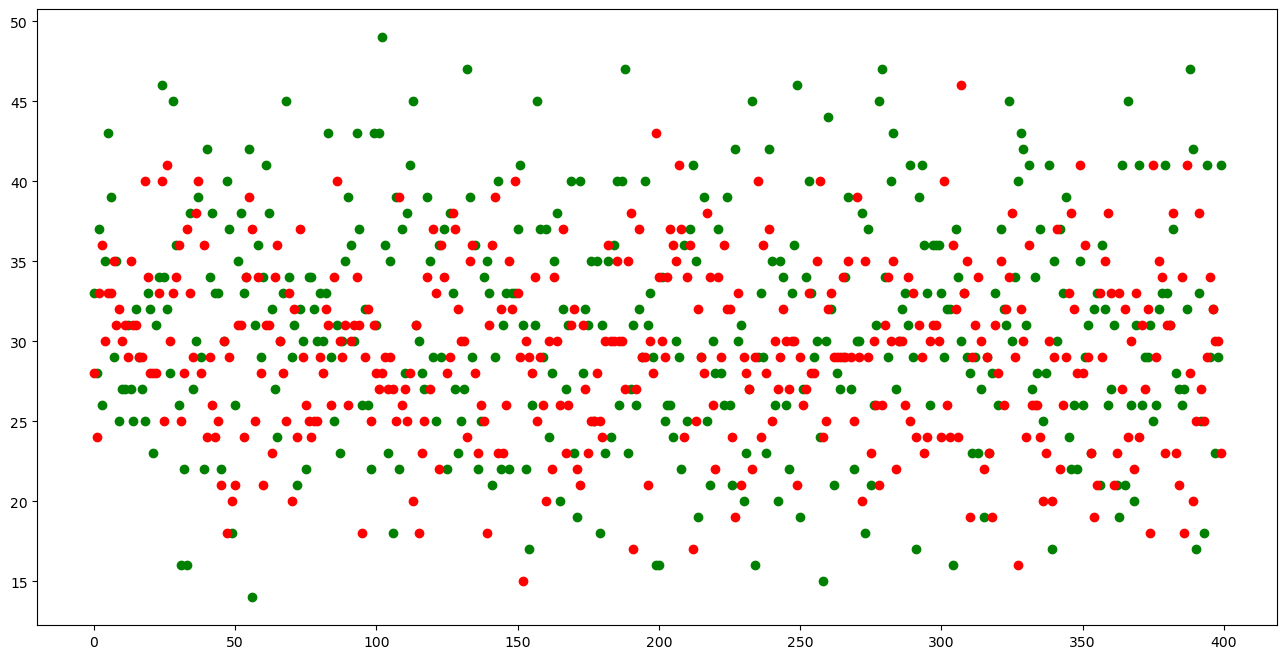

In [99]:
fig = plt.figure(figsize=[16,8])
plt.scatter(range(len(test_set.labels)),test_set.labels, color='green')
plt.scatter(range(len(preds)),preds, color='red')